In [ ]:
# default_exp funcs.merfish_eval

In [ ]:
%load_ext autoreload
%autoreload 2

# MERFISH routines

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
from starfish import data
import torch.tensor as T
import pprint

In [ ]:
base_path

'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [ ]:
mouse=1; sample = 1
bench_df = pd.read_csv(base_path + f'spots_mouse{mouse}sample{sample}.csv')
print(len(bench_df))

# code_ref = np.read_csv(base_path + '/additional_files/codebook.csv')
# targets = np.read_csv(base_path + '/additional_files/decode_fish/data/genes_combinatorial.txt')

17130008


In [ ]:
bla = open(base_path + '/additional_files/genes_combinatorial.txt').read()

In [ ]:
tra = bench_df[::100]

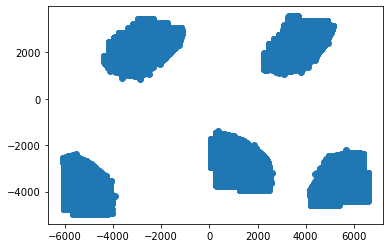

In [ ]:
plt.scatter(tra['global_x'],tra['global_y'])

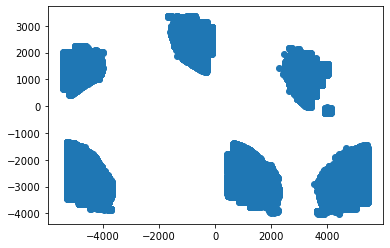

In [ ]:
plt.scatter(tra['global_x'],tra['global_y'])

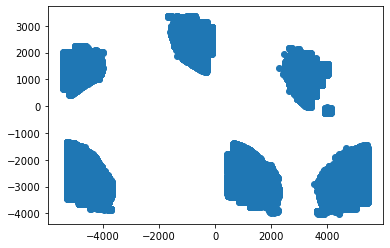

In [ ]:
plt.scatter(tra['global_x'],tra['global_y'])

In [ ]:
istdeco_df = get_istdeco()

156501


In [ ]:
bench_df, code_ref, targets = get_benchmark(1)

16443


In [ ]:
code_ref.shape

(140, 16)

In [ ]:
# pred_df = pd.read_csv('../data/results/MERFISH/exp_ci15_c2_ctf_n04.csv')
pred_df = pd.read_csv('../data/results/MERFISH/test.csv')

pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
pred_df['code'] = targets[pred_df['code_inds']]
len(pred_df)

22175

In [ ]:
int_arr = pred_df[[f'int_{i}' for i in range(16)]].values
inds = np.where(int_arr > 4)
dists = []

for i in range(len(inds[0])):
    n = inds[0][i]
    c = inds[1][i]
    
    if c >= 2 and c <=13:
        ints = int_arr[n, c-2:c+3][None]
        dists.append(ints/ints[0,2])
dists = np.concatenate(dists)
dists.mean(0)

array([0.15082698, 0.15928963, 1.        , 0.24509204, 0.15418076])

100%|███████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 190.09it/s]


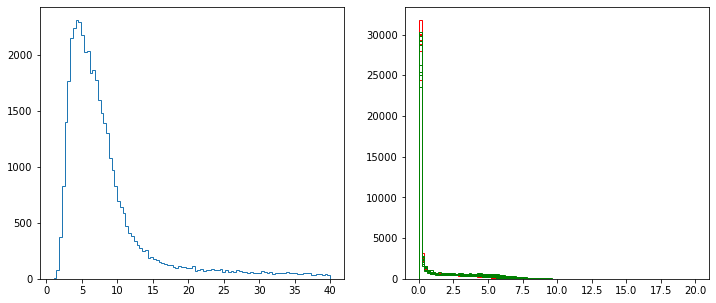

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(pred_df['comb_sig'], histtype='step', bins=np.linspace(1,40,101))

plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    plt.hist(pred_df[f'int_{i}'], histtype='step', color=color, bins=np.linspace(0,20,101))

In [ ]:
#export
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]
    return None

def norm_features(code, norm_order = 2):
    
    norm = np.linalg.norm(code, ord=norm_order, axis=1)
    code = code / norm[:, None]

    return code

def approximate_nearest_code(ref_code, pred_code, targets):
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='euclidean').fit(ref_code)
    metric_output, indices = nn.kneighbors(pred_code)
    gene_ids = np.ravel(targets.values[indices])

    return np.ravel(metric_output), gene_ids, indices

def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return 1-r

def bce_code(ref_code, pred_code):
    
    bce = torch.nn.BCELoss(reduction='none')
    return np.array(bce(T(ref_code, dtype=torch.float32), T(pred_code[None].repeat(len(ref_code),0), dtype=torch.float32)).mean(-1))

# export
def get_code_from_ints(pred_df, code_ref, targets, func=vcorrcoef, int_str='', p_str=''):
    
    int_keys = [f'int_{p_str}{i}{int_str}' for i in range(16)]
    int_pred = pred_df[int_keys].values

    res_df = pred_df.copy()

    code_err = []
    code_ind = []

    for i in range(len(int_pred)):

        code_errors = func(code_ref, int_pred[i])
        min_ind = np.argmin(code_errors)
        code_err.append(code_errors[min_ind])
        code_ind.append(min_ind)

    res_df['code_err'] = code_err
    res_df['code_inds'] = code_ind
    res_df['gene'] = targets[code_ind]
    
    return res_df

In [ ]:
# export
def match_bench(pred_df, bench_df):

    bench_match = bench_df.copy()
    pred_df.loc[:,'frame_idx'] = 0

    _,_,shift = matching(bench_match, pred_df, tolerance=250, print_res=False)
    print(shift)
    bench_match = shift_df(bench_match, shift=-np.array(shift))

    _,_,shift = matching(bench_match, pred_df, tolerance=250, print_res=False)

    bench_match = shift_df(bench_match, shift=-np.array(shift))
    _,matches,shift = matching(bench_match, pred_df, tolerance=250, print_res=True)
    
    return matches, bench_match

In [ ]:
res_df = pred_df

In [ ]:
res_sub = res_df.nsmallest(17500, 'comb_sig')
ist_sub = istdeco_df.nlargest(17500, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

In [ ]:
matches, bench_match = match_bench(ist_sub, bench_sub)

[102.95198432141108, 105.328270455659, 0.0]
Recall: 0.839
Precision: 0.662
Jaccard: 58.762
RMSE_vol: 88.503
Eff_3d: 39.513
FN: 2215.0 FP: 5915.0
Num. matches: 11585.000
Shift: 3.11,3.31,0.00


In [ ]:
matches, bench_match = match_bench(res_df, bench_sub)

[77.31801755296156, 77.48323121487252, 0.0]
Recall: 0.890
Precision: 0.267
Jaccard: 25.803
RMSE_vol: 89.322
Eff_3d: 13.399
FN: 1515.0 FP: 33811.0
Num. matches: 12285.000
Shift: 3.86,4.14,0.00


In [ ]:
matches, bench_match = match_bench(res_df, bench_sub)

[84.28537777546585, 84.29070381854076, 0.0]
Recall: 0.739
Precision: 0.460
Jaccard: 39.541
RMSE_vol: 89.132
Eff_3d: 24.891
FN: 3606.0 FP: 11981.0
Num. matches: 10194.000
Shift: 2.19,1.94,0.00


In [ ]:
# matches, bench_match = match_bench(istdeco_df, bench_sub)

In [ ]:
matches, bench_match = match_bench(res_sub, bench_sub)

[88.16242288220309, 87.9850437437544, 0.0]
Recall: 0.694
Precision: 0.547
Jaccard: 44.094
RMSE_vol: 89.697
Eff_3d: 28.328
FN: 4222.0 FP: 7922.0
Num. matches: 9578.000
Shift: 1.65,1.32,0.00


In [ ]:
matches['tar_gen'] = bench_match.set_index('loc_idx').loc[matches['loc_idx_tar'].values]['gene'].values
matches['pred_gen'] = res_sub.set_index('loc_idx').loc[matches['loc_idx_pred'].values]['gene'].values
(matches['tar_gen']==matches['pred_gen']).values.sum()/len(matches)

0.9745249530173313

In [ ]:
#export
def plot_gene_numbers(bench_counts, res_counts, title='', log=True, corr=True):
    
    if corr:
        r = np.corrcoef(bench_counts, res_counts)[0, 1]   
        r = np.round(r, decimals=3)
    else:
        r = [int(np.sum(bench_counts)), int(np.sum(res_counts))]
    x_lim = np.max([bench_counts.max(), res_counts.max()])
    x = np.linspace(0, x_lim)
    
    plt.scatter(bench_counts, res_counts, 50, zorder=2)
    plt.plot(x, x, '-k', zorder=1)

    plt.xlabel('Gene copy number Benchmark')
    plt.ylabel('Gene copy number DECODE')
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f'{title} r = {r}');

In [ ]:
#export
def plot_gene_panels(res_df, bench_df, targets, matches=None):
    
    bench_counts = DF(data=None, index=targets)
    bench_counts['Res_all'] = res_df.groupby('gene')['gene'].count()
    bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
    bench_counts = bench_counts.fillna(0)

    if matches is not None:
        fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
        fns = bench_df.loc[~bench_df['loc_idx'].isin(matches['loc_idx_tar'])]

        bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
        bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
    
    bench_counts=bench_counts.fillna(0)    
    
    print(len(bench_df), len(res_df))

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=False)

    binds = []
    for i,g in enumerate(targets):
        if 'Blank' in g:
            binds.append(g)

    plt.subplot(132)
    plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

    if 'Res_fp' in bench_counts:
        plt.subplot(133)
        plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=False)

13800 17500


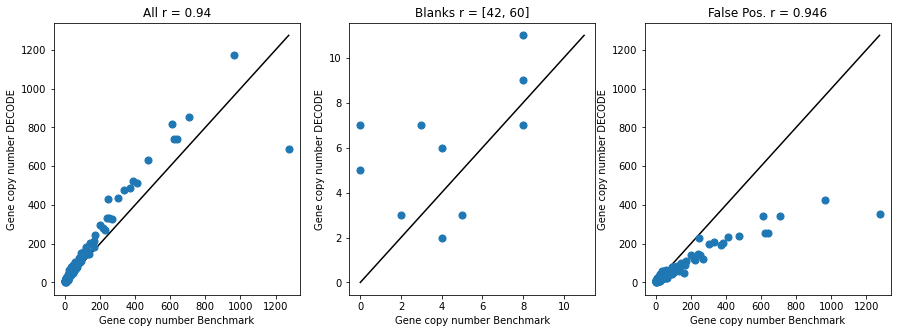

In [ ]:
plot_gene_panels(res_sub, bench_match, matches, targets)

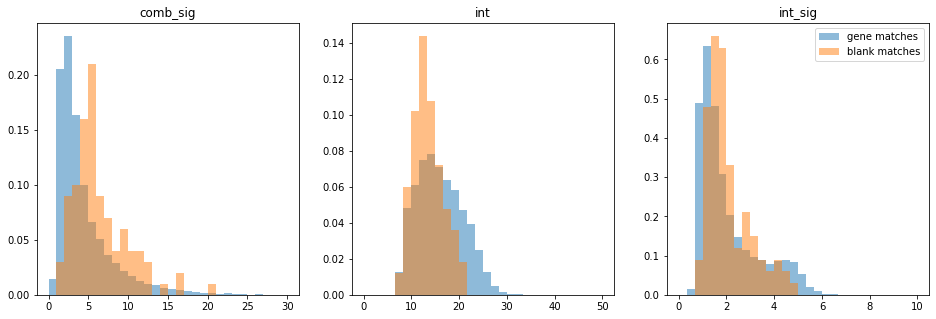

In [ ]:
metrics = ['comb_sig', 'int', 'int_sig']
bins = [np.linspace(0,30,31), np.linspace(0,50,31), np.linspace(0,10,31)]
plt.figure(figsize=(16,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])
plt.legend()

In [ ]:
# export
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

In [ ]:
# from decode_fish.funcs.visualization import *
# par_dict = {'res_df_nn':[res_df_nn, 'code_err', True],
#             'res_df_corr':[res_df_corr, 'code_err', True],
#             'res_df_bce':[res_df_bce, 'code_err', True],
#             'bench_df':[bench_df, 'total_magnitude', False]}

# roc_dict = {}
# for k in par_dict:
#     x, y = make_roc(*par_dict[k])
#     roc_dict[k] = [x, y]

In [ ]:
res_df = res_df[res_df['gene'] != 'MALAT1'] 
istdeco_df = istdeco_df[istdeco_df['gene'] != 'MALAT1'] 
bench_df = bench_df[bench_df['gene'] != 'MALAT1'] 

In [ ]:
from decode_fish.funcs.visualization import *
par_dict = {'DECODE':[res_df, 'comb_sig', True],
            'ISTDECO':[istdeco_df, 'quality', False],
            'benchmark':[bench_df, 'total_magnitude', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

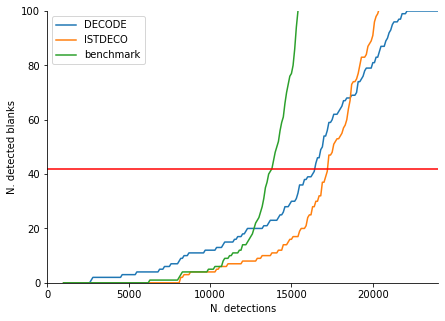

In [ ]:
import seaborn as sns
plt.figure(figsize=(7,5))
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
plt.plot([0,24000],[42,42], color='red')
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 24000)
plt.ylabel('N. detected blanks')
plt.xlabel('N. detections')
sns.despine()

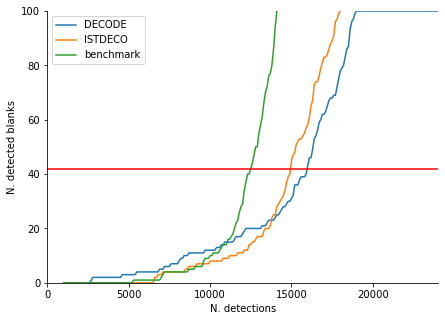

In [ ]:
import seaborn as sns
plt.figure(figsize=(7,5))
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
plt.plot([0,24000],[42,42], color='red')
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 24000)
plt.ylabel('N. detected blanks')
plt.xlabel('N. detections')
sns.despine()

In [ ]:
from decode_fish.funcs.visualization import *
par_dict = {'code_err':[res_df, 'code_err', True],
            'net_qual':[res_df, 'net_qual', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

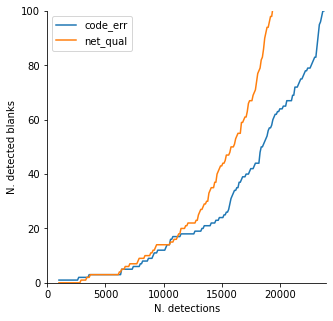

In [ ]:
plt.figure(figsize=(5,5))
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 24000)
plt.ylabel('N. detected blanks')
plt.xlabel('N. detections')
sns.despine()

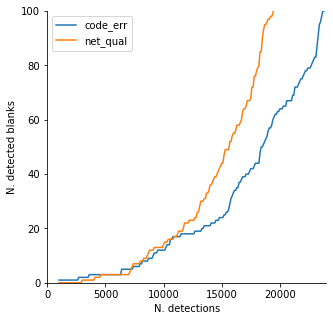

In [ ]:
plt.figure(figsize=(5,5))
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 24000)
plt.ylabel('N. detected blanks')
plt.xlabel('N. detections')
sns.despine()

In [ ]:
from decode_fish.funcs.visualization import *
roc_dict = {}

for i in tqdm(range(6)):
#     res_df[f'k_{i}'] = (1-i*0.2)*res_df['code_err'] + i*0.2*res_df['comb_sig']/100
    res_df[f'k_{i}'] = (1-i*0.2)*res_df['code_err'] + i*0.2*(1-res_df['corr_pred'])
    par_dict = {f'k_{i}':[res_df, f'k_{i}', True]}

    for k in par_dict:
        x, y = make_roc(*par_dict[k])
        roc_dict[k] = [x, y]
        
par_dict = {'bench_df':[bench_df, 'total_magnitude', False]}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]    

  0%|                                                                      | 0/6 [00:00<?, ?it/s]


KeyError: 'corr_pred'

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 22000)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist(bench_match['av_distance'], density=False, alpha=0.5, label='Benchmark')
_ = plt.hist(bench_match['av_distance'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5, label='FN')
_ = plt.hist(bench_match['av_distance'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5, label='TP')
plt.legend()

plt.subplot(122)
_ = plt.hist(bench_match['total_magnitude'], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='Benchmark')
_ = plt.hist(bench_match['total_magnitude'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='FN')
_ = plt.hist(bench_match['total_magnitude'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='TP')

In [ ]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

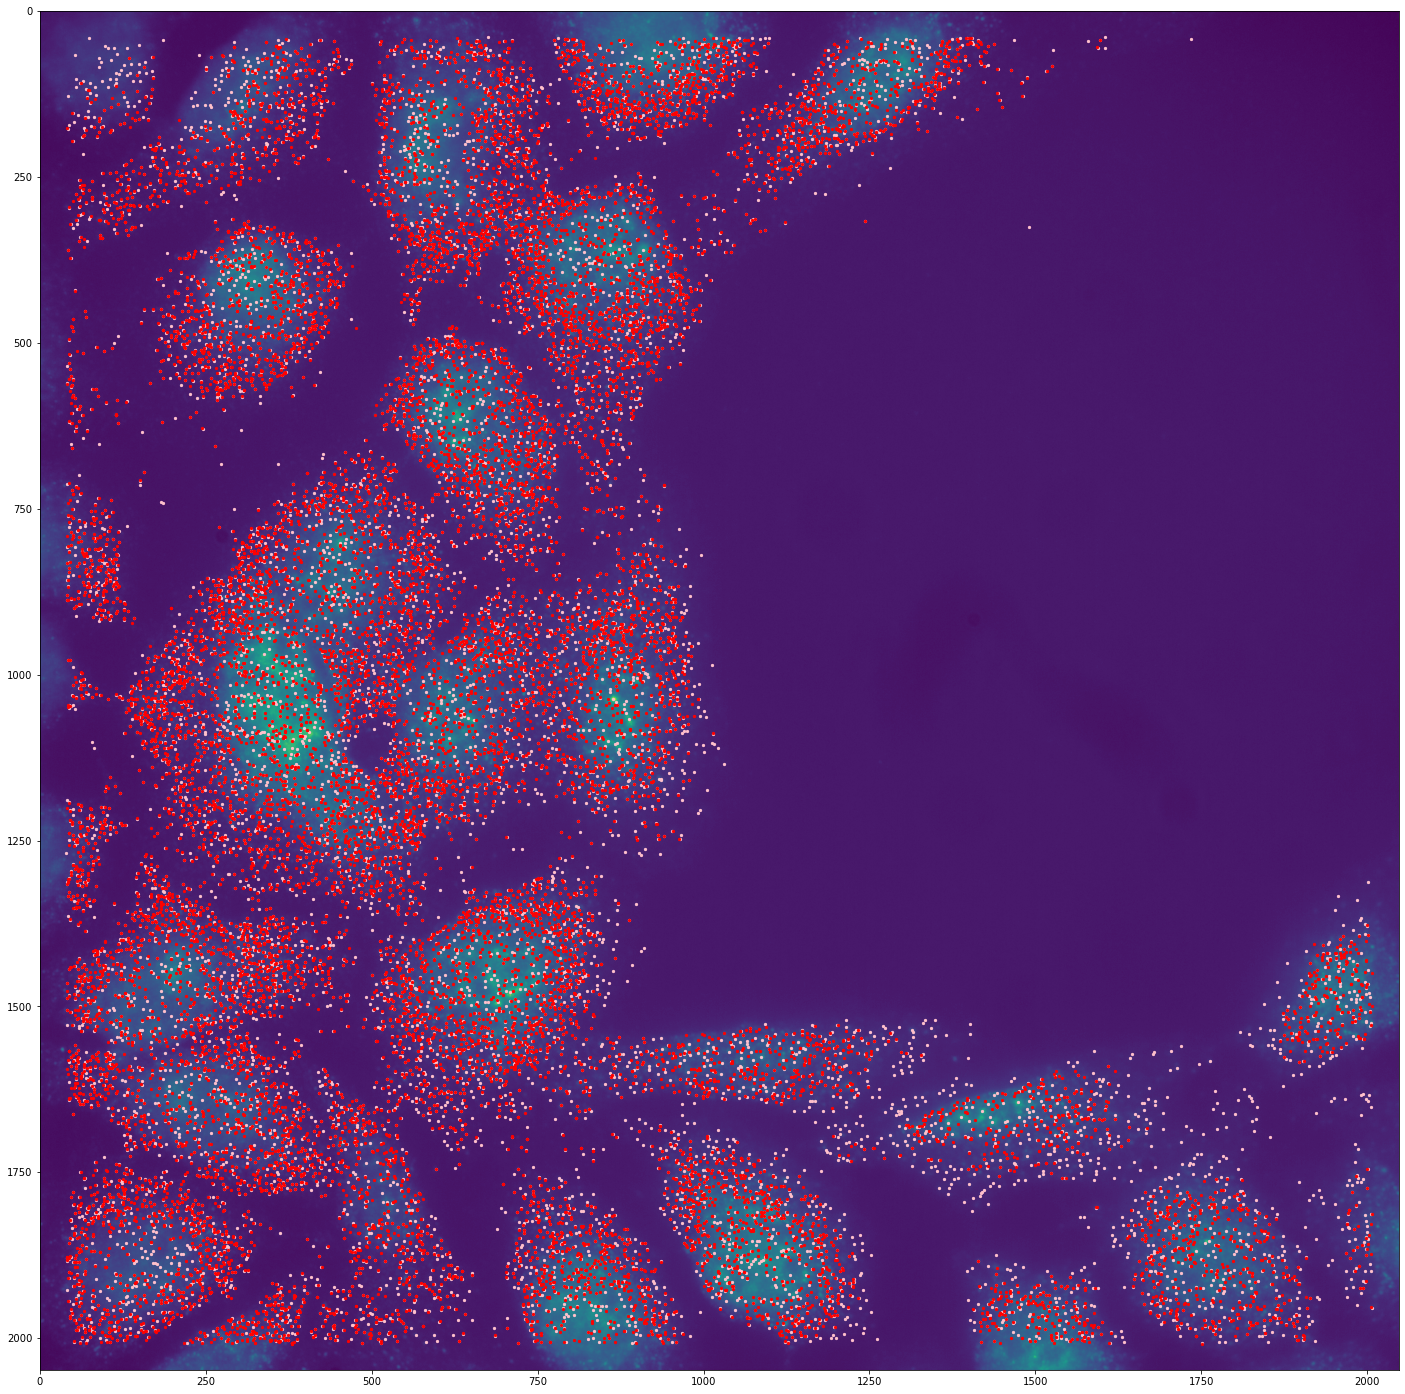

In [ ]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_sub)#[res_sub['gene']=='NOTCH2']
bench_px = nm_to_px(bench_match)#[bench_match['gene']=='NOTCH2']
plt.figure(figsize=(25,25))
plt.imshow(img[0,0])

plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=5)
plt.scatter(preds_px['x'],preds_px['y'], color='red', s=5)

In [ ]:
img_stack = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff')[:,0]

In [ ]:
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    tot_size = torch.Size([1, 16, size_xy*2+1, size_xy*2+1])
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

53
3.3382800000000046


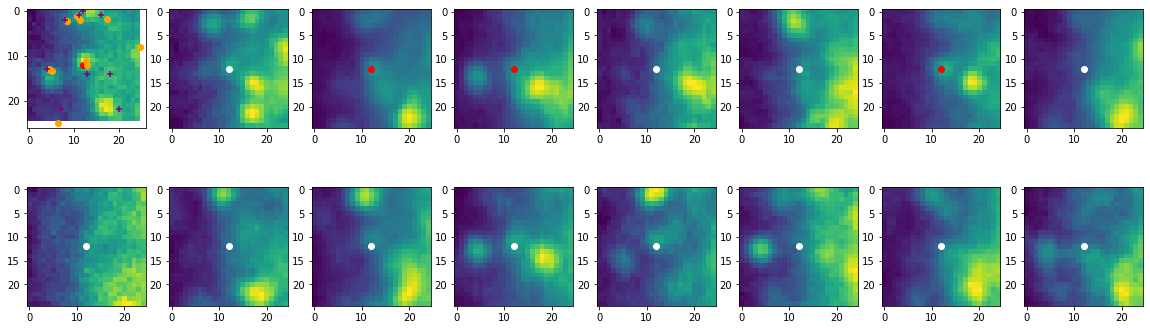

In [ ]:
# Random predictions 
sub = res_df
# Random blank 
sub = res_df[res_df['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
print(b_loc['comb_sig'])
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 12, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([12],[12], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted index.ipynb.
